In [33]:
from dataset import getMNIST
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from lenet5.nn import ConvNeuralNet
from utils import getTorchDevice
import torch
import random
from rich.jupyter import print
from rich.panel import Panel
from rich.console import Console
from rich.progress import (
    SpinnerColumn,
    BarColumn,
    TimeElapsedColumn,
    DownloadColumn,
    Progress,
    TaskID,
    TextColumn,
    TimeRemainingColumn,
    TransferSpeedColumn,
)
console = Console()
# Plot Font Config 

import matplotlib.font_manager

font_dirs = ['./IBM_Plex_Sans/']
font_files = matplotlib.font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    matplotlib.font_manager.fontManager.addfont(font_file)
plt.rcParams['font.family'] = 'IBM Plex Sans'

In [34]:
train_dataset, test_dataset, train_loader, test_loader = getMNIST(batch_size=64)

In [35]:
images = []
for i in range(64):
    images.append(train_dataset[i][0].reshape(32, 32))

In [36]:
SHOULD_SHOW_SAMPLE_IMAGES = False
if (SHOULD_SHOW_SAMPLE_IMAGES):
    fig = plt.figure(figsize=(8., 8.))
    grid = ImageGrid(fig, 111, 
                    nrows_ncols=(8, 8), 
                    axes_pad=0.1, 
                    )

    for ax, im in zip(grid, images):
        ax.imshow(im)
        ax.axis('off')
    plt.show()


In [37]:
device = getTorchDevice()
model = ConvNeuralNet(num_classes=10).to(device)
model.load("lenet5.pth")
device, model

(device(type='mps'),
 ConvNeuralNet(
   (layer1): Sequential(
     (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
     (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (layer2): Sequential(
     (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
     (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc): Linear(in_features=400, out_features=120, bias=True)
   (relu): ReLU()
   (fc1): Linear(in_features=120, out_features=84, bias=True)
   (relu1): ReLU()
   (fc2): Linear(in_features=84, out_features=10, bias=True)
 ))

Shape of output from NN: torch.Size([1, 400])

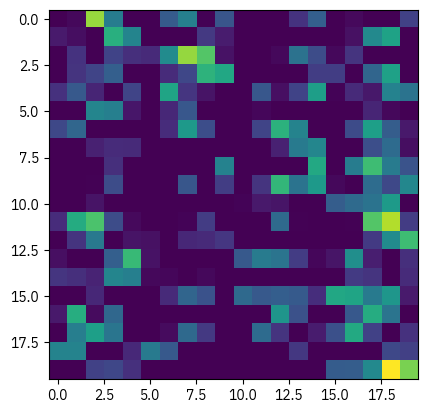

In [38]:
index = random.randint(0, len(images))
sample_image = images[index].float().to(device)
sample_image = sample_image.unsqueeze(0) 
sample_image = sample_image.unsqueeze(0) 
out = model.forwardWithoutLastLayer(x=sample_image)
print(f"Shape of output from NN: {out.shape}")
plt.imshow(out.detach().cpu().numpy().reshape(20, 20))

def getMidOutputOfNN(model, image):
    image = image.float().to(device)
    image = image.unsqueeze(0) 
    image = image.unsqueeze(0) 
    return model.forwardWithoutLastLayer(x=image)

In [39]:
def makeBinaryVector(floatVector):
    output_vector = floatVector.detach().cpu()
    num_intervals = 8
    interval_size = 1.0 / num_intervals

    # Create an array of boundaries
    boundaries = np.arange(0, 1 + interval_size, interval_size)

    # Quantize the output_vector
    quantized_indices = np.digitize(output_vector.numpy(), boundaries) - 1

    # Clip the indices to the valid range
    quantized_indices = np.clip(quantized_indices, 0, num_intervals - 1)

    # Generate unique binary patterns
    unique_patterns = np.eye(num_intervals)
    # Replace the quantized indices with their corresponding binary patterns
    return torch.tensor(unique_patterns[quantized_indices], dtype=torch.float).reshape(1, output_vector.shape[1]*8)

In [40]:
input_vectors_test = []
for i in range(64):
    input_vectors_test.append(makeBinaryVector(getMidOutputOfNN(model, images[i])).squeeze(0))

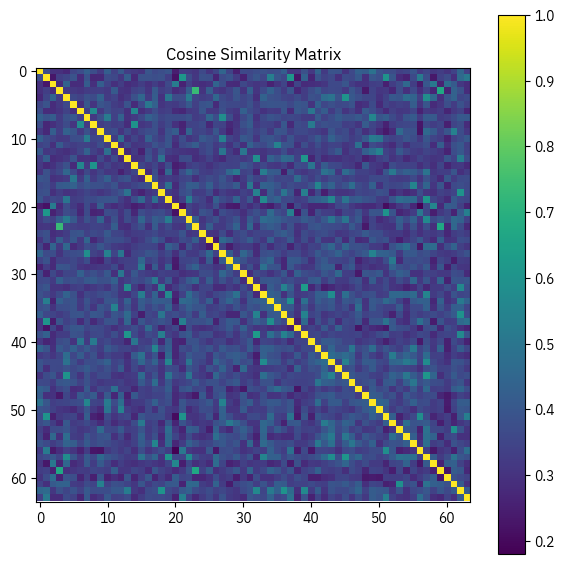

In [41]:
from scipy import spatial

similarities = np.zeros((64, 64))

def getSimilarities(input_vectors, index):
    _similarities = []
    for i in range(len(input_vectors)):
        _similarities.append(1 - spatial.distance.cosine(input_vectors[index], input_vectors[i]))
    return _similarities
for i in range(64):
    similarities[i] = getSimilarities(input_vectors_test, i)

plt.figure(figsize=(7, 7))
plt.title("Cosine Similarity Matrix")
plt.imshow(similarities, interpolation='nearest')
plt.colorbar()
  

In [42]:
import numpy as np
import torch
from sklearn.metrics.pairwise import cosine_similarity
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader


class HDCImageClassifier:
    def __init__(self, num_classes, vec_dim):
        self.num_classes = num_classes
        self.vec_dim = vec_dim
        self.item_memory = self.generate_item_memory_vectors()
        self.bundled_vectors = np.zeros((num_classes, vec_dim))

    def generate_item_memory_vectors(self):
        im_vectors = np.random.choice([1, -1], size=(self.num_classes, self.vec_dim))
        return im_vectors

    def encode(self, input_vector, label):
        return input_vector * self.item_memory[label]

    def train(self, input_vectors, labels):
        for input_vector, label in zip(input_vectors, labels):
            encoded_vector = self.encode(input_vector, label)
            self.bundled_vectors[label] = encoded_vector

    def decode(self, input_vector):
        similarities = cosine_similarity(input_vector.reshape(1, -1), self.bundled_vectors)
        return np.argmax(similarities)

    def predict(self, input_vectors):
        return np.array([self.decode(input_vector) for input_vector in input_vectors])


In [43]:
NUMBER_OF_TRAINING_IMAGES = 1000 # max 60, 000
NUMBER_OF_TEST_IMAGES = 64 # max 10, 000

train_images = []
train_labels = []

with Progress() as progress:
    load_train_task = progress.add_task("[cyan]Loading train images and labels...", total=NUMBER_OF_TRAINING_IMAGES)
    for i in range(NUMBER_OF_TRAINING_IMAGES):
        train_images.append(train_dataset[i][0].reshape(32, 32))
        train_labels.append(train_dataset[i][1])
        progress.update(load_train_task, advance=1, refresh=True)

test_images = []
test_labels = []

with Progress() as progress:
    load_test_task = progress.add_task("[cyan]Loading test images and labels...", total=NUMBER_OF_TEST_IMAGES)
    for i in range(NUMBER_OF_TEST_IMAGES):
        test_images.append(test_dataset[i][0].reshape(32, 32))
        test_labels.append(test_dataset[i][1])
        progress.update(load_test_task, advance=1, refresh=True)

train_vectors = []
with Progress() as progress:
    train_task = progress.add_task("[cyan]Processing train images...", total=len(train_images))
    for i in range(len(train_images)):
        train_vectors.append(makeBinaryVector(getMidOutputOfNN(model, train_images[i])).squeeze(0))
        progress.update(train_task, advance=1, refresh=True)

test_vectors = []
with Progress() as progress:
    test_task = progress.add_task("[cyan]Processing test images...", total=len(test_images))
    for i in range(len(test_images)):
        test_vectors.append(makeBinaryVector(getMidOutputOfNN(model, test_images[i])).squeeze(0))
        progress.update(test_task, advance=1, refresh=True)


Output()

Output()

Output()

Output()

In [45]:
# Train HDC classifier
num_classes = 10
vec_dim = 3200
hdc_classifier = HDCImageClassifier(num_classes, vec_dim)
hdc_classifier.train(train_vectors, np.array(train_labels))

# # Test HDC classifier
test_predictions = hdc_classifier.predict(test_vectors)
accuracy = np.mean(test_predictions == np.array(test_labels))

print(f'HDC classifier accuracy: {accuracy:.2%}')

HDC classifier accuracy: 14.06%